In [1]:
# Import modules
import pandas as pd
from transformers import pipeline, AutoTokenizer, TFAutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

/mnt/c/Users/kpali/Documents/Projects/Investment-Analytics-Data-Warehouse/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-12 20:58:03.196190: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 20:58:08.436408: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 20:58:12.432739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749733095.587156    2285 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 

In [2]:
# Create pipeline
finbert = pipeline("text-classification", model="ProsusAI/finbert", return_all_scores=True, truncation=True)

2025-06-12 21:01:38.002520: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-06-12 21:01:38.577574: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2025-06-12 21:01:38.783128: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2025-06-12 21:01:38.908026: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2025-06-12 21:01:43.186374: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are n

In [3]:
# Load the dataset
df = pd.read_json('company_news.json', orient='records')
df.head()

,date,ticker,title,description,source
0,2025-03-11 19:42:00+00:00,AAL,Why AerSale Shares Are up 26% YTD While Airlin...,"AerSale, a company that provides aftermarket s...",Investing.com
1,2025-03-12 18:17:09+00:00,AAL,Wall Street Rebounds As Cooling Inflation Draw...,Wall Street rebounded as cooling inflation dat...,Benzinga
2,2025-03-21 08:29:40+00:00,AAL,London's Heathrow Airport Shuts Down Due To Ma...,Heathrow Airport in London has been forced to ...,Benzinga
3,2025-03-24 13:00:00+00:00,AAL,The Gender Pay Gap Stalls in 2025 - Payscale's...,"Despite pay transparency laws, the gender pay ...",GlobeNewswire Inc.
4,2025-04-01 22:06:47+00:00,AAL,Why Southwest Airlines Stock Dived Today,"Jefferies downgraded several airline stocks, i...",The Motley Fool


In [4]:
# Get number of null values in each column
df.isnull().sum()

date           0
ticker         0
title          0
description    0
source         0
dtype: int64

In [5]:
# Retrieve maximum number of words within description column
max_length = df['description'].str.split().apply(len).max()
print(f'Maximum length of description: {max_length}')

Maximum length of description: 100


In [6]:
# Covert UTC to New York time
df['date'] = pd.to_datetime(df['date'], utc=True)
df['date'] = df['date'].dt.tz_convert('America/New_York')

In [11]:
# Function to calculate sentiment score from model output
def calculate_sentiment_score_batch(batch_outputs):
    scores = []
    for result in batch_outputs:
        sentiment_dict = {item['label'].lower(): item['score'] for item in result}
        score = (
            sentiment_dict.get('positive', 0) * 1.0 +
            sentiment_dict.get('neutral', 0) * 0.5 +
            sentiment_dict.get('negative', 0) * 0.0
        )
        scores.append(score)
    return scores

# Function to process in chunks
def process_in_batches(df, text_column, batch_size=500):
    sentiment_scores = []
    for start in range(0, len(df), batch_size):
        end = start + batch_size
        texts = df[text_column].iloc[start:end].fillna("").astype(str).tolist()
        batch_outputs = finbert(texts, truncation=True, max_length=512)
        batch_scores = calculate_sentiment_score_batch(batch_outputs)
        sentiment_scores.extend(batch_scores)
    return sentiment_scores

# Apply sentiment scoring in batches
df['title_sentiment_score'] = process_in_batches(df, 'title')
df['description_sentiment_score'] = process_in_batches(df, 'description')

In [12]:
# Save to CSV as calculating sentiment scores can take a while
df.to_csv('company_news_sentiment_scores.csv', index=False)

In [7]:
# Import company news sentiment scores
df = pd.read_csv('company_news_sentiment_scores.csv')

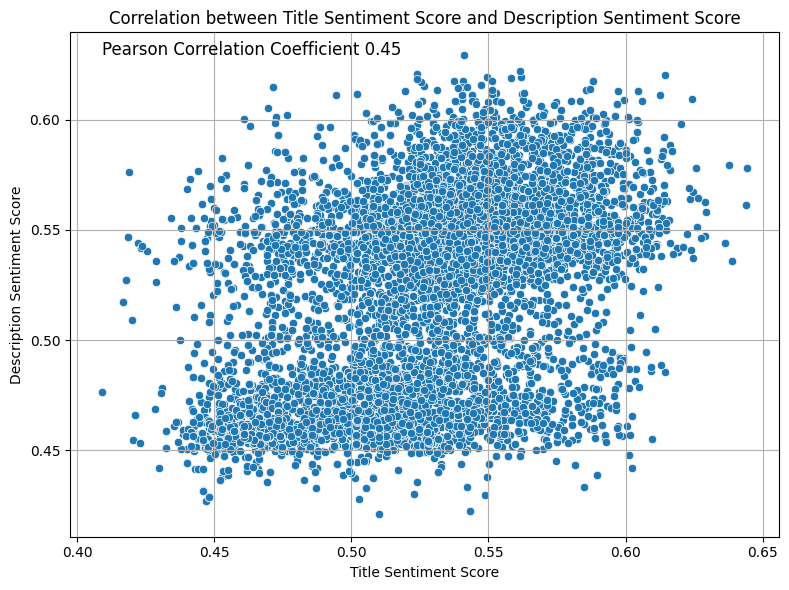

In [13]:
# Creation a correlation plot between title_sentiment_score and description_sentiment_score
x = df['title_sentiment_score']
y = df['description_sentiment_score']

# Compute Pearson correlation
r, _ = pearsonr(x, y)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.title('Correlation between Title Sentiment Score and Description Sentiment Score')
plt.text(min(x), max(y), f"Pearson Correlation Coefficient {r:.2f}", fontsize=12)
plt.xlabel('Title Sentiment Score')
plt.ylabel('Description Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Analyse the distribution of title_sentiment_score and description_sentiment_score
df[['title_sentiment_score','description_sentiment_score']].describe()

,title_sentiment_score,description_sentiment_score
count,12333.000000,12333.000000
mean,0.529215,0.524666
std,0.037984,0.042773
min,0.409061,0.421182
25%,0.506346,0.482064
50%,0.533552,0.538471
75%,0.553688,0.555542
max,0.644278,0.629183


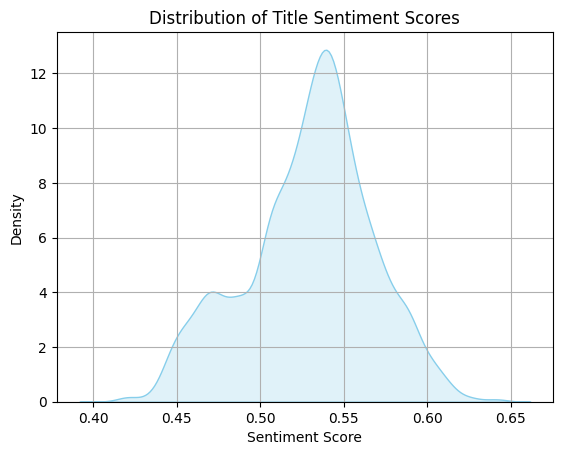

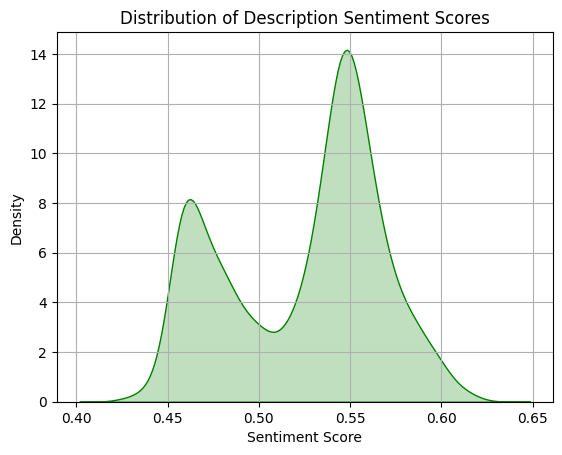

In [15]:
# Title Sentiment Distribution
sns.kdeplot(df['title_sentiment_score'], fill=True, color='skyblue')
plt.title("Distribution of Title Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Body Sentiment Distribution
sns.kdeplot(df['description_sentiment_score'], fill=True, color='green')
plt.title("Distribution of Description Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

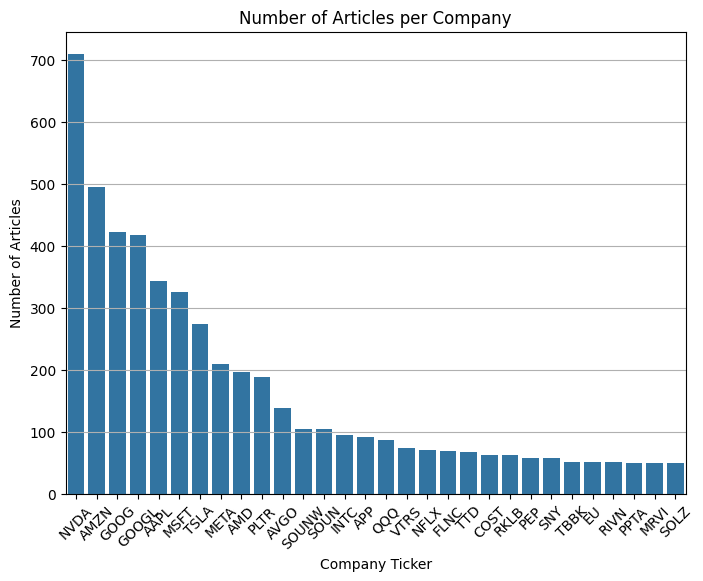

In [10]:
# Tickers with highest number of articles over a ~ 3month period
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='ticker', order=df['ticker'].value_counts().nlargest(30).index)
plt.title("Number of Articles per Company")
plt.xlabel("Company Ticker")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [12]:
# Summary statistics for number of articles by company by ticker
df['ticker'].value_counts().describe()

count    1964.000000
mean        6.279532
std        29.094358
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       710.000000
Name: count, dtype: float64